### Imports, loading features and DB

In [1]:
# improve speed of SVC in sklearn
from sklearnex import patch_sklearn
patch_sklearn("SVC")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import sys
sys.path.insert(0, '../..')

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from metrics.metrics_utils import get_froc_df_of_many_imgs_features
from metrics.metrics import froc_curve
from general_utils.plots import plot_froc
import seaborn as sns
from database.dataset import *
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

# set the seed for reproducible execution
rseed = np.random.seed(42)


In [4]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['train', 'validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15)

Load the features data

In [5]:
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria

In [6]:
features_data = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/all_data_df.f')
fnsdf = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/fns_df.f')
ignored = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/ingnored_df.f')

In [7]:
# retrieving each features set column names

fos_cols = [x for x in features_data if 'img' in x and x != 'img_id']
gabor_cols = [x for x in features_data if 'gabor_' in x]
wavelet_cols = [x for x in features_data if x[:6]
                == 'patch_' and x != 'patch_coordinates']
haar_cols = [x for x in features_data if 'haar' in x]

features_sets = {'fos': fos_cols, 'gabor': gabor_cols, 'wavelet': wavelet_cols,
                 'haar': haar_cols,
                 'all_features': fos_cols+gabor_cols+wavelet_cols+haar_cols}


# Grid-Search

In [8]:
param_grid = [
    {'SVC__C': [1, 10, 100], 'SVC__kernel': ['linear']},
    {'SVC__C': [1, 10, 100, ], 'SVC__degree':[
        3, 5, 7, 10], 'SVC__kernel': ['poly']},
    {'SVC__C': [1, 10, 100, ], 'SVC__gamma': [
                0.01, 0.1, 1, 'scale'], 'SVC__kernel': ['rbf']},
]


pipe = Pipeline([('scaler', MinMaxScaler()), ('SVC', SVC())])


clf = GridSearchCV(estimator=pipe,
                   param_grid=param_grid,
                   scoring='roc_auc',
                   n_jobs=8,
                   cv=5)


FP2TP_rate = 10
positive_mask = (features_data.label > 0)
positive_train_part = features_data[positive_mask]
negative_train_part = features_data[~positive_mask].sample(
    FP2TP_rate*positive_mask.sum())
train_df = pd.concat(
    [positive_train_part, negative_train_part]).sample(frac=1.)
train_y = train_df.label
train_X = train_df[features_sets['all_features']]

clf.fit(train_X, train_y)


/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('SVC', SVC())]),
             n_jobs=8,
             param_grid=[{'SVC__C': [1, 10, 100], 'SVC__kernel': ['linear']},
                         {'SVC__C': [1, 10, 100], 'SVC__degree': [3, 5, 7, 10],
                          'SVC__kernel': ['poly']},
                         {'SVC__C': [1, 10, 100],
                          'SVC__gamma': [0.01, 0.1, 1, 'scale'],
                          'SVC__kernel': ['rbf']}],
             scoring='roc_auc')

In [13]:
clf.best_params_

{'SVC__C': 10, 'SVC__gamma': 0.1, 'SVC__kernel': 'rbf'}

# Cascade

### First Stage (removing easy negative)

In [8]:
clf = SVC(**{'C': 10,
             'gamma': 0.1,
             'kernel': 'rbf',
             'probability':True
        })

In [9]:
# adding case_id column for case_wise K-fold CV splits
imgid2caseid = db.df[['img_id', 'case_id']].set_index('img_id').to_dict()['case_id']
features_data['case_id'] = [imgid2caseid[imgid] for imgid in features_data['img_id']]

In [10]:
# splitting all candidates between db train and validation partitions

all_train_db_ids = db.df[db.df.partition == 'train'].img_id.values
all_valid_db_ids = db.df[db.df.partition == 'validation'].img_id.values

general_train_mask = features_data.img_id.isin(all_train_db_ids)
general_valid_mask = features_data.img_id.isin(all_valid_db_ids)

train_features = features_data[general_train_mask]
test_features = features_data[general_valid_mask]


In [11]:
kfolds = 10
FP2TP_rate = 10

features = features_sets['all_features']

# splitting data into train/validation case-wise
all_train_case_ids = train_features.case_id.unique()
kfolds_case_splits = np.array_split(all_train_case_ids, kfolds)

predicted_test_df = []
balanced_train_df = []

# kfold CV
for valid_case_ids in tqdm(kfolds_case_splits):

    # split data into test
    test_split_mask = train_features.case_id.isin(valid_case_ids)

    # split into train and take into account cleaned data with no mC in the borders of the patch
    cleaned_features_data = train_features[~test_split_mask]

    # and sampling to a predefined 1:FP2TP_rate TP:FP samples
    positive_mask = (cleaned_features_data.label > 0)
    positive_train_part = cleaned_features_data[positive_mask]
    negative_train_part = cleaned_features_data[~positive_mask].sample(
        FP2TP_rate*positive_mask.sum())

    train_df = pd.concat(
        [positive_train_part, negative_train_part]).sample(frac=1.)

    test_df = train_features[test_split_mask]

    train_y = train_df.label
    test_y = test_df.label

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_df[features].values)
    test_X_scaled = scaler.transform(test_df[features].values)

    clf.fit(train_X_scaled, train_y)

    train_y_predicted = clf.predict_proba(train_X_scaled)[:, 1]
    test_y_predicted = clf.predict_proba(test_X_scaled)[:, 1]

    test_df['cv_fold_predict_proba'] = test_y_predicted
    predicted_test_df.append(test_df)


  0%|          | 0/10 [00:00<?, ?it/s]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
/tmp/ipykernel_336835/573672590.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cv_fold_predict_proba'] = test_y_predicted
 10%|█         | 1/10 [00:23<03:31, 23.48s/it]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC

In [12]:
predicted_test_df = pd.concat(predicted_test_df)

In [13]:
fpr, tpr, thrs = roc_curve(predicted_test_df.label,
                           predicted_test_df.cv_fold_predict_proba)

prc, rc, thrs_pr = precision_recall_curve(
    predicted_test_df.label, predicted_test_df.cv_fold_predict_proba)

filtered_fp_prc = []
total_fp = np.sum(~predicted_test_df.label)
for ks in sorted(tpr):

    max_conf_thr_required = thrs[np.argmax(tpr >= ks)]

    filtered_fp = np.sum((~predicted_test_df.label) & (
        predicted_test_df.cv_fold_predict_proba <= max_conf_thr_required))/total_fp
    filtered_fp_prc.append(filtered_fp)

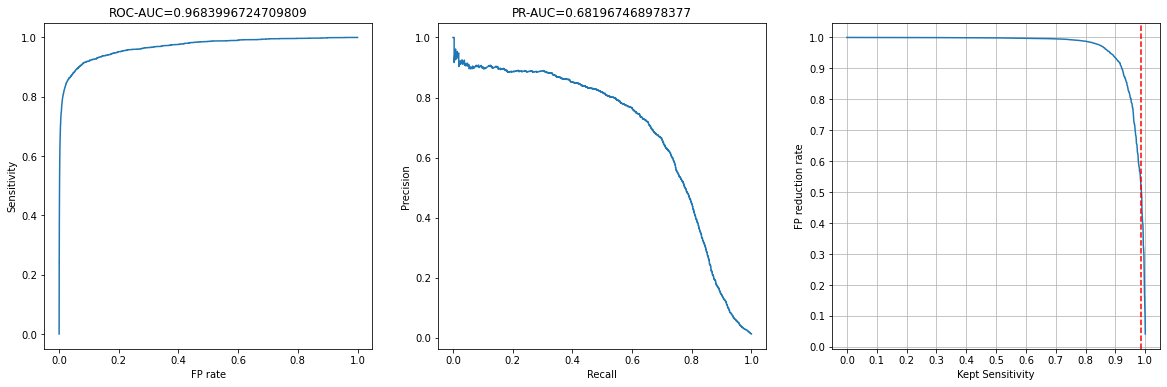

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(fpr, tpr)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title(
    f'ROC-AUC={roc_auc_score(predicted_test_df.label, predicted_test_df.cv_fold_predict_proba)}')

axs[1].plot(rc, prc)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR-AUC={auc(rc, prc)}')

axs[2].plot(tpr, filtered_fp_prc)
axs[2].set_xlabel('Kept Sensitivity')
axs[2].set_ylabel('FP reduction rate')
axs[2].grid(which='major', alpha=0.9)
axs[2].axvline(0.986, color = 'r', linestyle = '--')
axs[2].set_xticks(np.arange(min(tpr), max(tpr)+0.1, 0.1))
axs[2].set_yticks(np.arange(0, 1.1, 0.1))

plt.show()


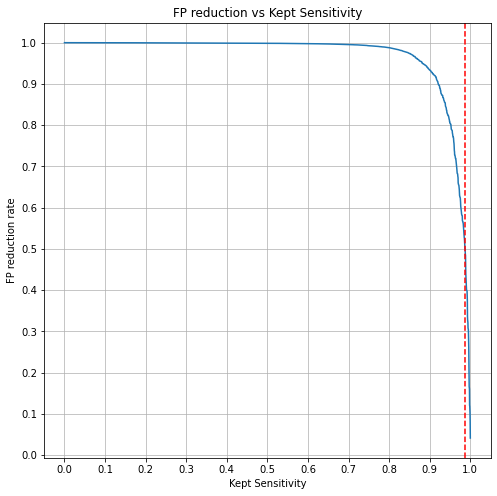

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

axs.plot(tpr, filtered_fp_prc)
axs.set_xlabel('Kept Sensitivity')
axs.set_ylabel('FP reduction rate')
axs.grid(which='major', alpha=0.9)
axs.axvline(0.986, color = 'r', linestyle = '--')
axs.set_xticks(np.arange(min(tpr), max(tpr)+0.1, 0.1))
axs.set_yticks(np.arange(0, 1.1, 0.1))
plt.title('FP reduction vs Kept Sensitivity')
plt.show()

In [16]:
cascade1_tpr = tpr.copy()
cascade1_thrs = thrs.copy()
cascade1_labels = predicted_test_df.label.values
cascade1_probas = predicted_test_df.cv_fold_predict_proba.values

keep_sens_thr = .986
max_conf_thr_required = cascade1_thrs[np.argmax(cascade1_tpr >= keep_sens_thr)]

filtered_fp = np.sum((~cascade1_labels) & (
    cascade1_probas <= max_conf_thr_required))/total_fp


msg = (
    f"Selected keep_sens_thr={keep_sens_thr}\n"
    f'max_conf_thr_required to keep given sensitivity is {max_conf_thr_required:.5f}\n'
    f'Filtering out all candidates with confidence <={max_conf_thr_required:.5f} is estimated to reduce FP by {100*filtered_fp:.2f} %'
)
print(msg)

Selected keep_sens_thr=0.986
max_conf_thr_required to keep given sensitivity is 0.00380
Filtering out all candidates with confidence <=0.00380 is estimated to reduce FP by 51.43 %


### Displaying removed easy negatives

In [17]:
removed_easy_negatives = predicted_test_df[predicted_test_df.cv_fold_predict_proba <= max_conf_thr_required].sample(
    100)
removed_easy_negatives


,haar_0,haar_1,haar_2,haar_3,haar_4,haar_5,haar_6,haar_7,haar_8,haar_9,...,patch_glcm_dissimilarity_HH1_1,patch_glcm_dissimilarity_HH1_2,candidate_coordinates,patch_coordinates,img_id,repeted_idxs,matching_gt,label,case_id,cv_fold_predict_proba
30539,-0.126365,-0.113885,0.128445,0.175247,0.136765,-0.165367,0.166927,0.111804,0.095164,-0.177847,...,63.944444,79.542857,"[47, 1622, 0]","[[1615, 1629], [40, 54]]",22580015,307.0,NaN,False,6200187f3f1ccc18,0.000707
95726,-0.214724,-0.336985,0.141104,0.202454,0.226556,-0.379053,0.117003,0.110868,0.225679,-0.256792,...,63.055556,60.400000,"[351, 1437, 0]","[[1430, 1444], [344, 358]]",24055627,661.0,NaN,False,6f1aef40b3775182,0.001628
35260,-0.170826,-0.183735,0.060241,0.175559,0.123494,-0.269363,0.112306,0.139415,0.116179,-0.256454,...,67.277778,66.457143,"[772, 2408, 0]","[[2401, 2415], [765, 779]]",22580654,137.0,NaN,False,fe7d005dcbbfb46d,0.003342
310967,-0.104661,-0.168644,0.206780,0.278390,0.288559,-0.204237,0.196610,0.336441,0.291949,-0.140254,...,61.555556,56.800000,"[104, 1363, 0]","[[1356, 1370], [97, 111]]",53582395,1373.0,NaN,False,3f0db31711fc9795,0.003081
312069,0.048729,0.022034,0.030085,0.090254,0.036441,0.088136,0.083898,0.016102,-0.031780,0.114831,...,56.277778,53.171429,"[316, 148, 0]","[[141, 155], [309, 323]]",53582395,2475.0,NaN,False,3f0db31711fc9795,0.000280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87042,-0.010605,-0.058469,0.020063,0.124391,0.040126,-0.125824,0.104328,0.047865,0.059616,-0.077959,...,65.194444,67.942857,"[718, 728, 3]","[[721, 735], [711, 725]]",24055274,2135.0,NaN,False,1e10aef17c9fe149,0.001298
103090,-0.121483,-0.129522,0.029924,0.074140,0.079500,-0.223761,0.024565,0.058955,0.041090,-0.215721,...,60.138889,70.142857,"[404, 1908, 0]","[[1901, 1915], [397, 411]]",24055806,202.0,NaN,False,f0f1a133837b5137,0.000685
183859,-0.086182,-0.119302,0.048077,0.169160,0.173433,-0.106125,0.043803,0.102564,0.266738,-0.073006,...,70.527778,72.800000,"[168, 1144, 0]","[[1137, 1151], [161, 175]]",50994562,1332.0,NaN,False,de4c34099d6ef8de,0.001411
198912,-0.080439,-0.036106,0.130713,0.094607,0.135740,-0.094150,0.089580,0.123400,0.121115,-0.138483,...,66.416667,77.885714,"[83, 2145, 0]","[[2138, 2152], [76, 90]]",50995899,334.0,NaN,False,c94d8a1ebd452afe,0.001024


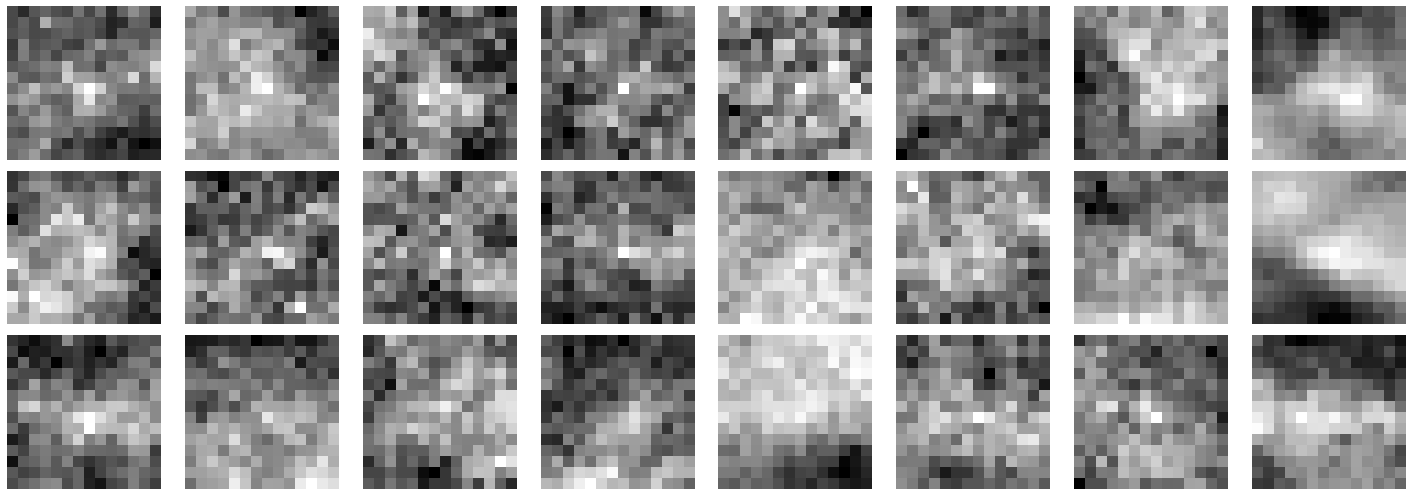

In [18]:
img_plot_idx = 0

fig, axs = plt.subplots(3, 8, sharex=True, sharey=True, figsize=(20, 7))

for r in range(3):
    for c in range(8):
        img_idx = db.df[db.df.img_id ==
                        removed_easy_negatives.iloc[img_plot_idx].img_id].index[0]
        image = db[img_idx]['img']
        (y1, y2), (x1, x2) = removed_easy_negatives.iloc[img_plot_idx].patch_coordinates
        axs[r, c].imshow(image[y1:y2, x1:x2], cmap='gray')
        axs[r, c].set_axis_off()
        img_plot_idx += 1

plt.tight_layout()
# plt.title('Removed Easy negatives')
plt.show()


Training final first stage model



In [19]:
# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = (train_features.label > 0)
positive_train_part = train_features[positive_mask]
negative_train_part = train_features[~positive_mask].sample(
    FP2TP_rate*positive_mask.sum())


train_df = pd.concat(
    [positive_train_part, negative_train_part]).sample(frac=1.)

first_stage_model = Pipeline([('scaler', MinMaxScaler()), ('svc', clf)])
first_stage_model.fit(train_df[features], train_df.label)


INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc', SVC(C=10, gamma=0.1, probability=True))])

### Second Stage (retraining on harder samples)

In [20]:
print(max_conf_thr_required)
train_df_stage2 = predicted_test_df[predicted_test_df.cv_fold_predict_proba >
                                    max_conf_thr_required]


0.0037978951851362383


In [21]:
print(len(predicted_test_df), len(train_df_stage2))


236368 116239


In [22]:
kfolds = 10
FP2TP_rate = 10

features = features_sets['all_features']
# splitting data into train/validation case-wise
all_train_case_ids = train_df_stage2.case_id.unique()
kfolds_case_splits = np.array_split(all_train_case_ids, kfolds)

predicted_test_df2 = []

# kfold CV
for valid_case_ids in tqdm(kfolds_case_splits):

    # split data into test
    test_split_mask = train_df_stage2.case_id.isin(valid_case_ids)

    # split into train and take into account cleaned data with no mC in the borders of the patch
    cleaned_features_data = train_df_stage2[~test_split_mask]

    # and sampling to a predefined 1:FP2TP_rate TP:FP samples
    positive_mask = (cleaned_features_data.label > 0)
    positive_train_part = cleaned_features_data[positive_mask]
    negative_train_part = cleaned_features_data[~positive_mask].sample(
        FP2TP_rate*positive_mask.sum())

    train_df = pd.concat(
        [positive_train_part, negative_train_part]).sample(frac=1.)

    test_df = train_df_stage2[test_split_mask]

    train_y = train_df.label
    test_y = test_df.label

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_df[features].values)
    test_X_scaled = scaler.transform(test_df[features].values)

    clf.fit(train_X_scaled, train_y)

    train_y_predicted = clf.predict_proba(train_X_scaled)[:, 1]
    test_y_predicted = clf.predict_proba(test_X_scaled)[:, 1]

    test_df['cv_fold_predict_proba'] = test_y_predicted
    predicted_test_df2.append(test_df)


  0%|          | 0/10 [00:00<?, ?it/s]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
/tmp/ipykernel_336835/4103976767.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cv_fold_predict_proba'] = test_y_predicted
 10%|█         | 1/10 [00:18<02:42, 18.08s/it]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SV

In [23]:
predicted_test_df2 = pd.concat(predicted_test_df2)


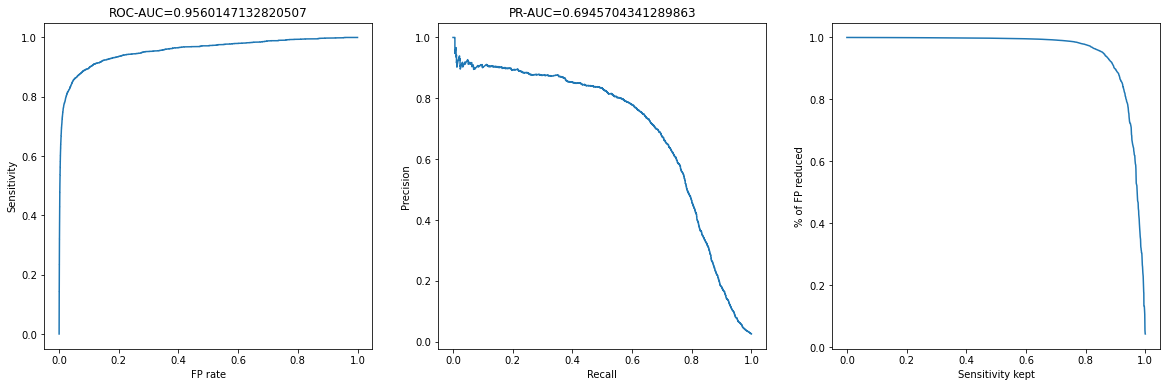

In [24]:
fpr, tpr, thrs = roc_curve(predicted_test_df2.label,
                           predicted_test_df2.cv_fold_predict_proba)

prc, rc, thrs_pr = precision_recall_curve(
    predicted_test_df2.label, predicted_test_df2.cv_fold_predict_proba)

filtered_fp_prc = []
total_fp = np.sum(~predicted_test_df2.label)
for ks in tpr:

    keep_sens_thr = ks
    max_conf_thr_required_ks = thrs[np.argmax(tpr >= keep_sens_thr)]

    filtered_fp = np.sum((~predicted_test_df2.label) & (
        predicted_test_df2.cv_fold_predict_proba <= max_conf_thr_required_ks))/total_fp
    filtered_fp_prc.append(filtered_fp)


fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(fpr, tpr)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title(
    f'ROC-AUC={roc_auc_score(predicted_test_df2.label, predicted_test_df2.cv_fold_predict_proba)}')

axs[1].plot(rc, prc)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR-AUC={auc(rc, prc)}')

axs[2].plot(tpr, filtered_fp_prc)
axs[2].set_xlabel('Sensitivity kept')
axs[2].set_ylabel('% of FP reduced')
plt.show()


In [25]:
# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = (train_df_stage2.label > 0)
positive_train_part = train_df_stage2[positive_mask]
negative_train_part = train_df_stage2[~positive_mask].sample(
    FP2TP_rate*positive_mask.sum())


train_df = pd.concat(
    [positive_train_part, negative_train_part]).sample(frac=1.)

second_stage_model = Pipeline([('scaler', MinMaxScaler()), ('svc', clf)])
second_stage_model.fit(train_df[features], train_df.label)


INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc', SVC(C=10, gamma=0.1, probability=True))])

In [26]:
train_df_stage2.label.sum()/len(train_df_stage2)


0.024398007553402903

### Final comparison between clssifiers

In [27]:
# load models directly
# with open('/home/vzalevskyi/projects/data/cascade/cascade_models.pkl', 'rb') as f:
#     first_stage_model, second_stage_model, cascade1_tpr, cascade1_thrs, cascade1_labels, cascade1_probas, keep_sens_thr = pickle.load(f)


In [28]:
val1st_pred = first_stage_model.predict_proba(test_features[features])[:, 1]
val2st_pred = second_stage_model.predict_proba(test_features[features])[:, 1]

test_features_cascaded = test_features[val1st_pred > max_conf_thr_required]
val2st_casc_pred = val2st_pred[val1st_pred > max_conf_thr_required]

INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU


In [29]:
# adding lost TP (due to drop of easy negatives) as additional FN
stag1_droped_easy_neg = test_features[val1st_pred <= max_conf_thr_required]
stag1_droped_easy_neg = stag1_droped_easy_neg[stag1_droped_easy_neg.label]
stag1_droped_easy_neg['label'] = 'FN'
stag1_droped_easy_neg['repeted_idxs'] = False


stag1_droped_easy_neg['x'] = [x[0] for x in stag1_droped_easy_neg.candidate_coordinates.values]
stag1_droped_easy_neg['y'] = [x[1] for x in stag1_droped_easy_neg.candidate_coordinates.values]
stag1_droped_easy_neg['radius'] = [x[2] for x in stag1_droped_easy_neg.candidate_coordinates.values]

valid_fnsdf = fnsdf[fnsdf.img_id.isin(test_features.img_id.unique())]
cascaded_fns = pd.concat([stag1_droped_easy_neg, valid_fnsdf])

In [30]:
normal_imgs_ids = db.get_normal_imgs_ids()

froc_df_1st = get_froc_df_of_many_imgs_features(
    test_features[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    val1st_pred,
    normal_imgs_ids
)

sens1, avgs_fp_per_image1, _ = froc_curve(
    froc_df_1st, non_max_supression=True, cut_on_50fpi=False)


froc_df_2st = get_froc_df_of_many_imgs_features(
    test_features[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    val2st_pred,
    normal_imgs_ids
)

sens2, avgs_fp_per_image2, _ = froc_curve(
    froc_df_2st, non_max_supression=True, cut_on_50fpi=False)


froc_df_cascade = get_froc_df_of_many_imgs_features(
    test_features_cascaded[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    val2st_casc_pred,
    normal_imgs_ids
)

sens_casc, avgs_fp_per_image_casc, _ = froc_curve(
    froc_df_cascade, non_max_supression=True, cut_on_50fpi=False)

/home/vzalevskyi/projects/calc-det/notebooks/experiments/../../metrics/metrics_utils.py:522: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fns_df.loc[:, 'detection_labels'] = 'FN'
/home/vzalevskyi/projects/calc-det/notebooks/experiments/../../metrics/metrics_utils.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fns_df.loc[:, 'pred_scores'] = 0.
/home/vzalevskyi/projects/calc-det/notebooks/experiments/../../metrics/metrics_utils.py:524: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

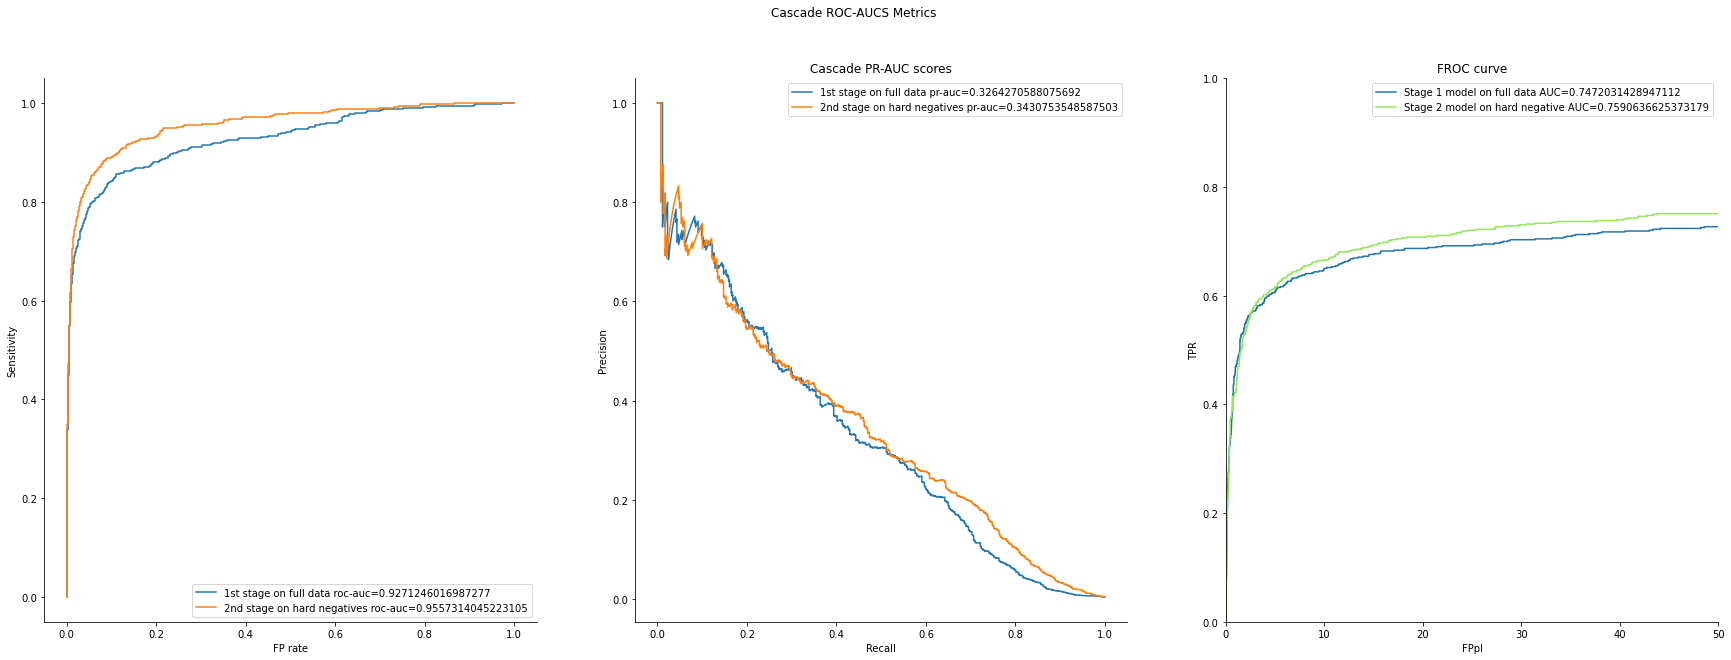

In [35]:
fpr_train1, tpr_train1, _ = roc_curve(test_features.label, val1st_pred)
prc_train1, rc_train1, _ = precision_recall_curve(
    test_features.label, val1st_pred)

fpr_test2, tpr_test2, _ = roc_curve(test_features.label, val2st_pred)
prc_test2, rc_test2, _ = precision_recall_curve(
    test_features.label, val2st_pred)

fpr_test3, tpr_test3, _ = roc_curve(test_features_cascaded.label, val2st_casc_pred)
prc_test3, rc_test3, _ = precision_recall_curve(
    test_features_cascaded.label, val2st_casc_pred)


fig, axs = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle('Cascade ROC-AUCS Metrics')
axs[0].plot(fpr_train1, tpr_train1)
# axs[0].plot(fpr_test2, tpr_test2)
axs[0].plot(fpr_test3, tpr_test3)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].legend([f'1st stage on full data roc-auc={roc_auc_score(test_features.label, val1st_pred, )}',
            #    f'2nd stage on full data roc-auc={roc_auc_score(test_features.label, val2st_pred)}',
               f'2nd stage on hard negatives roc-auc={roc_auc_score(test_features_cascaded.label, val2st_casc_pred)}'])

axs[1].plot(rc_train1, prc_train1)
# axs[1].plot(rc_test2, prc_test2)
axs[1].plot(rc_test3, prc_test3)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'Cascade PR-AUC scores')
axs[1].legend([f'1st stage on full data pr-auc={auc(rc_train1, prc_train1)}',
            #    f'2nd stage on full data pr-auc={auc(rc_test2, prc_test2)}',
               f'2nd stage on hard negatives pr-auc={auc(rc_test3, prc_test3)}'])



plot_froc(avgs_fp_per_image1, sens1, cut_on_50fpi=True,
          ax=axs[2], color=(0.12, 0.46, 0.7, 1.0))


# plot_froc(avgs_fp_per_image2, sens2,
#           cut_on_50fpi=True, ax=axs[2], color=(0.1, 0.49, 0.07, 1.0))


plot_froc(avgs_fp_per_image_casc, sens_casc,
          cut_on_50fpi=True, ax=axs[2], color=(0.569944, 0.914625, 0.341379, 1.0))


avgs_fp_per_image1 = np.asarray(avgs_fp_per_image1)
avgs_fp_per_image2 = np.asarray(avgs_fp_per_image2)
avgs_fp_per_image3 = np.asarray(avgs_fp_per_image_casc)
axs[2].legend([f'Stage 1 model on full data AUC={auc(avgs_fp_per_image1/avgs_fp_per_image1.max(), sens1)}',
            #    f'Stage 2 model on full data AUC={auc(avgs_fp_per_image2/avgs_fp_per_image2.max(), sens2)}',
               f'Stage 2 model on hard negative AUC={auc(avgs_fp_per_image3/avgs_fp_per_image3.max(), sens_casc)}'])
plt.show()


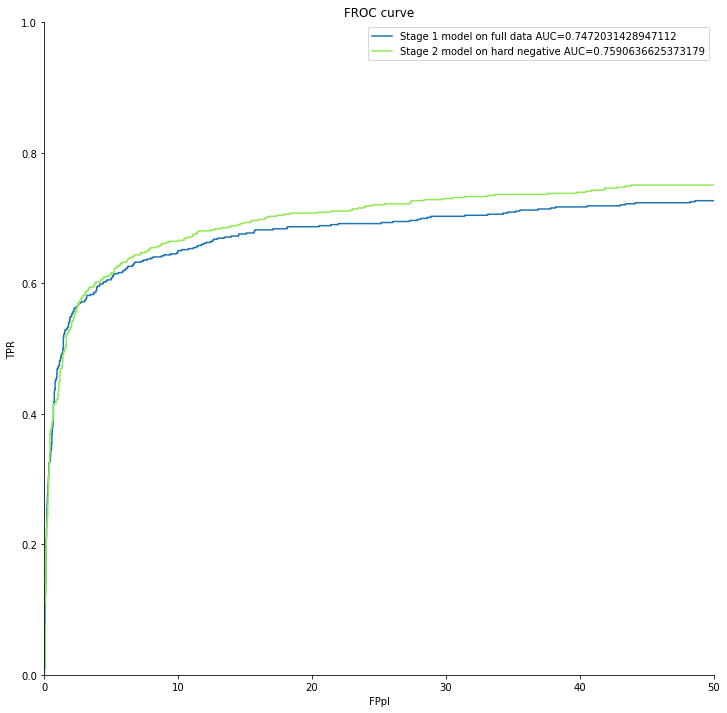

In [37]:
fig = plt.figure(figsize=(12, 12))
axs = fig.add_subplot(1, 1, 1)

plot_froc(avgs_fp_per_image1, sens1, cut_on_50fpi=True,
          ax=axs, color=(0.12, 0.46, 0.7, 1.0))


# plot_froc(avgs_fp_per_image2, sens2,
#           cut_on_50fpi=True, ax=axs, color=(0.1, 0.49, 0.07, 1.0))


plot_froc(avgs_fp_per_image_casc, sens_casc,
          cut_on_50fpi=True, ax=axs, color=(0.569944, 0.914625, 0.341379, 1.0))


avgs_fp_per_image1 = np.asarray(avgs_fp_per_image1)
# avgs_fp_per_image2 = np.asarray(avgs_fp_per_image2)
avgs_fp_per_image3 = np.asarray(avgs_fp_per_image_casc)
axs.legend([f'Stage 1 model on full data AUC={auc(avgs_fp_per_image1/avgs_fp_per_image1.max(), sens1)}',
            #    f'Stage 2 model on full data AUC={auc(avgs_fp_per_image2/avgs_fp_per_image2.max(), sens2)}',
               f'Stage 2 model on hard negative AUC={auc(avgs_fp_per_image3/avgs_fp_per_image3.max(), sens_casc)}'])
plt.show()


# Looking into bad results

Save locally some examples of bad predictions or missed candidates

In [36]:
test_features['confidence'] = val2st_pred

test_df = test_features


/tmp/ipykernel_220314/2031025059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features['confidence'] = val2st_pred


In [37]:
bad_res_FP = test_df[~test_df.label].sort_values(
    by=['confidence'], ascending=False).drop(columns=features_sets['all_features'])
bad_res_FN = test_df[test_df.label].sort_values(
    by=['confidence'], ascending=True).drop(columns=features_sets['all_features'])

bad_res_FN_normals = bad_res_FN[bad_res_FN.img_id.isin(
    db.get_normal_imgs_ids())]
bad_res_FP_normals = bad_res_FP[bad_res_FP.img_id.isin(
    db.get_normal_imgs_ids())]


for _, bad_res in tqdm(bad_res_FN.head(100).iterrows(), total=100):
    img_id = bad_res['img_id']
    # ((2767, 2781), (1029, 1043))
    test_img_id = db.df[db.df.img_id == img_id].index.values[0]
    test_img = db[test_img_id]['img']
    test_mask = db[test_img_id]['lesion_mask']

    original_test_mask = cv2.imread(
        str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
    (ppx1, ppx2), (ppy1, ppy2) = bad_res['patch_coordinates']

    if original_test_mask is not None:
        fig, axs = plt.subplots(4, 3, figsize=(20, 8))
        if db.img_df[db.img_df.img_id == img_id]['side'].values[0] == "R":
            original_test_mask = cv2.flip(original_test_mask, 1)
    else:
        fig, axs = plt.subplots(4, 2, figsize=(20, 8))
    for didx, delta in enumerate([0, 10, 50, 100]):
        axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,
                            ppy1-delta:ppy2+delta], cmap='gray')
        axs[didx, 0].axis('off')
        axs[didx, 0].set_title(f'Original zoom=-{delta}')

        axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta,
                            ppy1-delta:ppy2+delta], cmap='gray', vmin=0)
        axs[didx, 1].axis('off')
        axs[didx, 1].set_title(f'INBreast DB mask zoom=-{delta}')
        if original_test_mask is not None:
            axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2 +
                                delta, ppy1-delta:ppy2+delta] > 0, cmap='gray', vmin=0)
            axs[didx, 2].axis('off')
            axs[didx, 2].set_title(f'Original DB mask zoom=-{delta}')
    plt.savefig(f'bad_res_FN/conf={bad_res["confidence"]}_{img_id}_{_}.jpg',
                bbox_inches="tight", dpi=600, pad_inches=0, transparent=False)
    plt.close(fig)


  5%|▌         | 5/100 [00:10<03:09,  2.00s/it]/tmp/ipykernel_112095/3175446880.py:24: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
/tmp/ipykernel_112095/3175446880.py:28: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], cmap='gray', vmin=0)
/tmp/ipykernel_112095/3175446880.py:32: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0, cmap='gray', vmin=0)
100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


# Save cascade models

In [36]:
with open('/home/vzalevskyi/projects/data/cascade/cascade_models.pkl', 'wb') as f:
    pickle.dump((first_stage_model, second_stage_model, 
                 cascade1_tpr, cascade1_thrs, 
                 cascade1_labels, cascade1_probas,
                 keep_sens_thr), f)
